In [3]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

# 전이 학습(Transfer Learning)

## 특성 추출 기법

### 이미지 데이터 전처리 방법 정의

In [2]:
train_path = '/home/xogns5037/Basic_PyTorch/data/catanddog/train'
test_path = '/home/xogns5037/Basic_PyTorch/data/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=False
)

print(len(train_dataset))
print(len(test_dataset))

385
98


### 사전 훈련된 모델 내려받기

In [3]:
resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# vgg16 = models.vgg16(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# inception = models.inception_v3(pretrained=True)
# googlenet = models.googlenet(pretrained=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
# mobilenet_v2 = models.mobilenet_v2(pretrained=True)
# mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
# mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
# mnasnet = models.mnasnet1_0(pretrained=True)

/home/xogns5037/.conda/envs/torch_book/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xogns5037/.conda/envs/torch_book/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 사전 훈련된 모델의 파라미터 학습 유무 지정

In [4]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

### 모델의 파라미터 값 확인

In [5]:
# ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)

# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0372,  0.0185,  0.0255,  ...,  0.0302, -0.0242,  0.0254],
        [ 0.0222,  0.0377,  0.0192,  ..., -0.0347, -0.0185,  0.0298]])
fc.bias tensor([-0.0290, -0.0097])


### 모델 객체 생성 및 손실 함수 정의

In [6]:
model = models.resnet18(pretrained=True) # 모델 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 모델의 완전연결층은 가중치 학습
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 모델 학습을 위한 함수 생성

In [7]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_loss = 0.0
        runing_corrects = 0    
    
        for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            runing_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장
        
        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = runing_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc)
        torch.save(model.state_dict(), os.path.join('/home/xogns5037/Basic_PyTorch/data/catanddog/model', '{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위해 저장해 둠
        print()

    time_elapsed = time.time() - since # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    return acc_history, loss_history # 모델의 정확도와 오차를 반환

### 파라미터 학습 결과를 옵티마이저에 전달

In [8]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) # 파라미터 학습 결과를 저장
        print("\t", name)

optimizer = optim.Adam(params_to_update) # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


### 모델 학습

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용 여부 확인
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device) # 학습 함수 호출

Epoch 0/12
----------


Loss: 0.7057 Acc: 0.5870

Epoch 1/12
----------
Loss: 0.4378 Acc: 0.7870

Epoch 2/12
----------
Loss: 0.3707 Acc: 0.8494

Epoch 3/12
----------
Loss: 0.2983 Acc: 0.8987

Epoch 4/12
----------
Loss: 0.2543 Acc: 0.9065

Epoch 5/12
----------
Loss: 0.2783 Acc: 0.8935

Epoch 6/12
----------
Loss: 0.2223 Acc: 0.9169

Epoch 7/12
----------
Loss: 0.2738 Acc: 0.8805

Epoch 8/12
----------
Loss: 0.2907 Acc: 0.8597

Epoch 9/12
----------
Loss: 0.3454 Acc: 0.8234

Epoch 10/12
----------
Loss: 0.3021 Acc: 0.8597

Epoch 11/12
----------
Loss: 0.1845 Acc: 0.9273

Epoch 12/12
----------
Loss: 0.2182 Acc: 0.8935

Training complete in 0m 26s
Best val Acc: 0.927273


### 테스트 데이터 평가 함수 생성

In [10]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob('/home/xogns5037/Basic_PyTorch/data/catanddog/model/*.pth')
    saved_models.sort()
    print('saved_models:', saved_models)
    
    for model_path in saved_models:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
    
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)  # 가장 높은 클래스 인덱스
            preds[preds >= 0.5] = 1 # torch.max()로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0 # torch.max()로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels).int().sum()
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 배치 크기로 나누기
        print('Acc: {:.4f}'.format(epoch_acc))
        acc_history.append(epoch_acc)
        print()
            
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
        
    return acc_history


In [11]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_models: ['/home/xogns5037/Basic_PyTorch/data/catanddog/model/00.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/01.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/02.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/03.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/04.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/05.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/06.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/07.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/08.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/09.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/10.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/11.pth', '/home/xogns5037/Basic_PyTorch/data/catanddog/model/12.pth']
Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/00.pth


/tmp/ipykernel_22641/2931580735.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Acc: 0.7551

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/01.pth
Acc: 0.8571

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/02.pth
Acc: 0.8980

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/03.pth
Acc: 0.9184

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/04.pth
Acc: 0.8878

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/05.pth
Acc: 0.9184

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/06.pth
Acc: 0.9490

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/07.pth
Acc: 0.9490

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/08.pth
Acc: 0.9082

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/09.pth
Acc: 0.8980

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/10.pth
Acc: 0.8878

Loading model /home/xogns5037/Basic_PyTorch/data/catanddog/model/11.pth
Acc: 0.8878

Loading model /home/xogns5037/Basic_PyTorch/data/cat

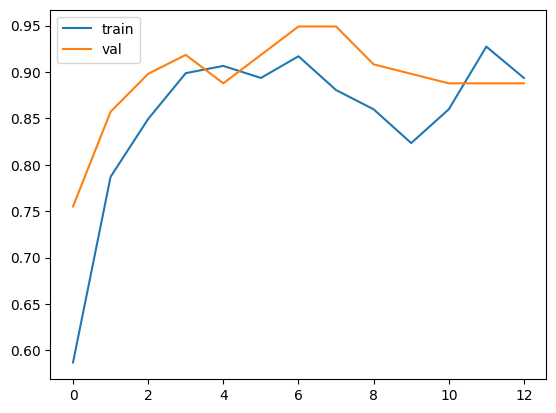

In [12]:
train_acc_hist = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_hist]
val_acc_hist = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_hist]

plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='val')
plt.legend()
plt.show()

### 예측 이미지 출력을 위한 전처리 함수

In [5]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array(0.5, 0.5, 0.5) + np.array(0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [6]:
exam = np.array([-1.8, -1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam)
print(np.clip(exam, -0.5, 0.5)) # 입력 값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용

[-1.8 -1.2 -0.7  0.   0.8  1.4  1.9]
[-0.5 -0.5 -0.5  0.   0.5  0.5  0.5]
